In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import CubicSpline
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import math

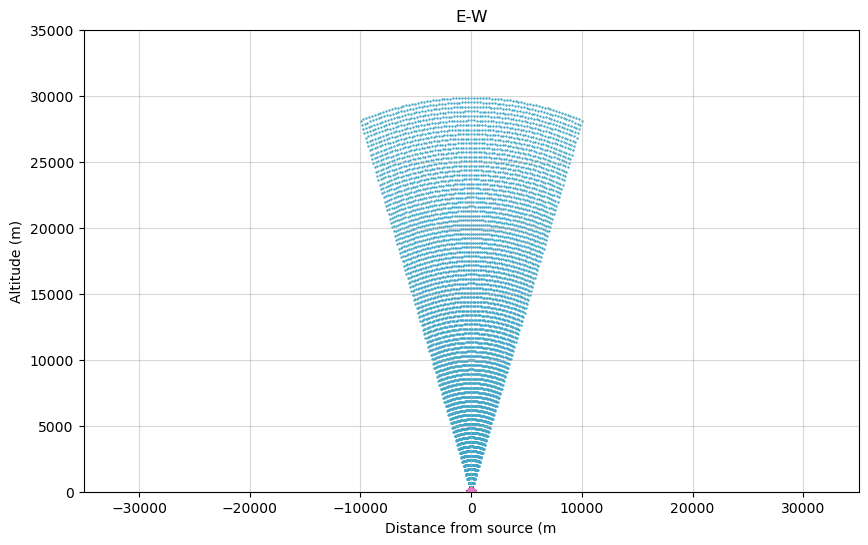

In [13]:
df = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/ideal_cnds_0.csv')
group_t = df.groupby('time')

plt.figure(figsize=(10, 6))

for t in df['time'].unique():
    if t!=0:
        df_ = group_t.get_group(t).sort_values('x')
        wave_eq = CubicSpline(df_['x'], df_['z'], bc_type='natural')
        
        x_l = []
        y_l = []
        x_w = []
        y_w = []
        for x0 in df_['x'].to_numpy():
            dz_dx = wave_eq.derivative()(x0)
            
            if dz_dx != 0:
                n_slope = np.rad2deg(np.arctan(-1 / dz_dx))
                
                # print(f"x0: {x0}, dz_dx: {dz_dx}, n_slope: {n_slope}")
                
                if np.abs(n_slope) >= 70:  # Temporarily relaxing the condition
                    land_x = x0 + wave_eq(x0) * dz_dx
                    x_w.append(x0)
                    y_w.append(wave_eq(x0))
                    x_l.append(land_x)
                    y_l.append(0)
        
        plt.scatter(x_w, y_w,s=0.5, color='#43A6C6')
        plt.scatter(x_l, y_l)

dist = 35 * 1000
plt.xlim((-dist, dist))
plt.ylim((0, dist))
plt.title('E-W')
plt.xlabel('Distance from source (m')
plt.ylabel("Altitude (m)")
plt.grid(alpha=0.5)
plt.show()


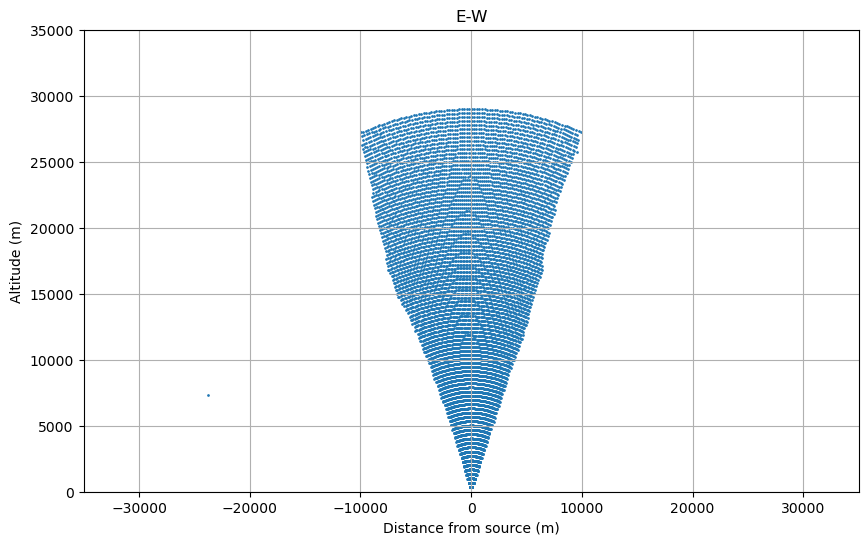

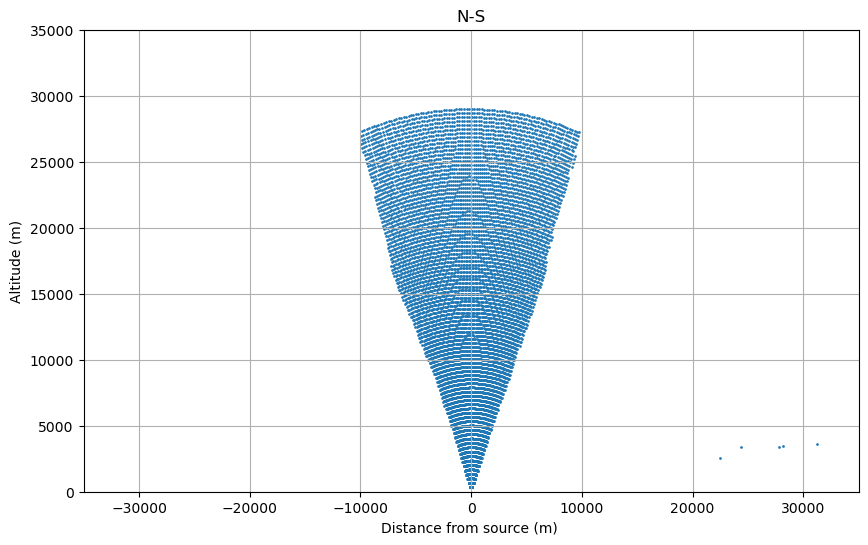

In [2]:
def plot_wave_fronts(df, axis, axis_label):
    group_t = df.groupby('time')
    x_l = []
    y_l = []
    
    for t in df['time'].unique():
        if t != 0:
            df_ = group_t.get_group(t).sort_values(axis)
            df_ = df_.drop_duplicates(subset=axis)
            
            wave_eq = CubicSpline(df_[axis], df_['z'])
            
            for x0 in df_[axis].to_numpy():
                dz_dx = wave_eq.derivative()(x0)
                if dz_dx != 0:
                    n_slope = np.rad2deg(np.arctan(-1 / dz_dx))
                    
                    if np.abs(n_slope) >= 70:
                        land_x = x0 + wave_eq(x0) * dz_dx
                        # if np.abs(land_x) < 50:
                        x_l.append(x0)
                        y_l.append(wave_eq(x0))
    
    plt.scatter(x_l, y_l, s=0.9)
    plt.xlim((-dist, dist))
    plt.ylim((0, dist))
    plt.xlabel(axis_label)
    plt.ylabel("Altitude (m)")
    plt.grid()

# Load the data
dfa = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp_alglib_CS.csv')
dfa = dfa[dfa['z'] >= 0]
dfa = dfa[(dfa['theta'] <= np.pi/2) & (dfa['theta'] >= -np.pi/2)]
dfa = dfa[dfa['phi'] >= 0]

dist = 35 * 1000

plt.figure(figsize=(10, 6))

# E-W plot
df_phi_non_zero = dfa[dfa['phi'] != 0].reset_index(drop=True)
plot_wave_fronts(df_phi_non_zero, 'y', 'Distance from source (m)')
plt.title('E-W')


plt.figure(figsize=(10, 6))
# N-S plot
df_phi_zero = dfa[dfa['phi'] == 0].reset_index(drop=True)
plot_wave_fronts(df_phi_zero, 'x', 'Distance from source (m) ')
plt.title('N-S')
plt.show()

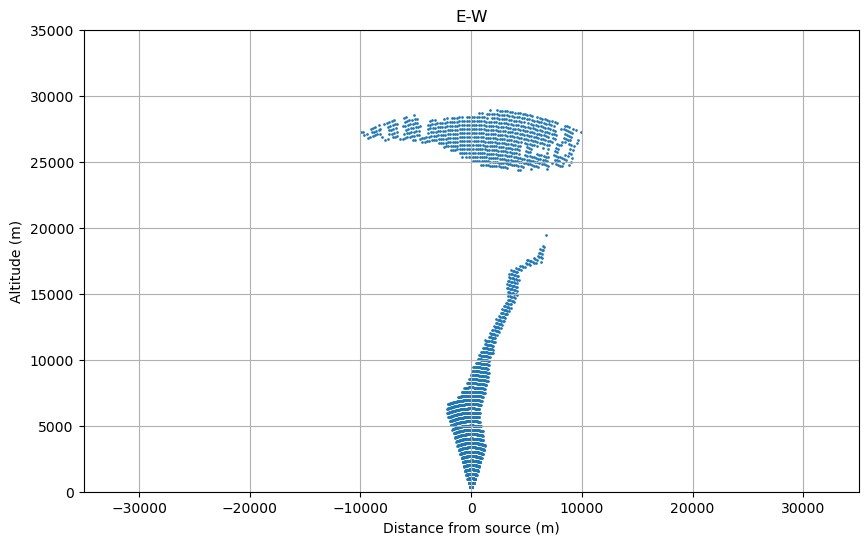

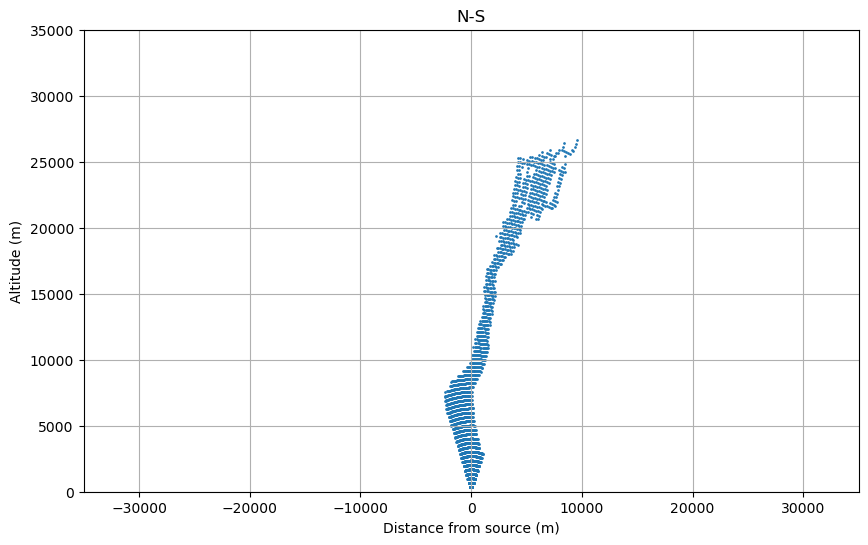

In [4]:
def plot_wave_fronts(df, axis, axis_label):
    group_t = df.groupby('time')
    x_l = []
    y_l = []
    
    for t in df['time'].unique():
        if t != 0:
            df_ = group_t.get_group(t).sort_values(axis)
            df_ = df_.drop_duplicates(subset=axis)
            
            wave_eq = CubicSpline(df_[axis], df_['z'])
            
            for x0 in df_[axis].to_numpy():
                dz_dx = wave_eq.derivative()(x0)
                if dz_dx != 0:
                    n_slope = np.rad2deg(np.arctan(-1 / dz_dx))
                    
                    if np.abs(n_slope) >= 70:
                        land_x = x0 + wave_eq(x0) * dz_dx
                        if np.abs(land_x) < 50:
                            x_l.append(x0)
                            y_l.append(wave_eq(x0))
    
    plt.scatter(x_l, y_l, s=0.9)
    plt.xlim((-dist, dist))
    plt.ylim((0, dist))
    plt.xlabel(axis_label)
    plt.ylabel("Altitude (m)")
    plt.grid()

# Load the data
dfa = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp_alglib_CS.csv')
dfa = dfa[dfa['z'] >= 0]
dfa = dfa[(dfa['theta'] <= np.pi/2) & (dfa['theta'] >= -np.pi/2)]
dfa = dfa[dfa['phi'] >= 0]

dist = 35 * 1000

plt.figure(figsize=(10, 6))

# E-W plot
df_phi_non_zero = dfa[dfa['phi'] != 0].reset_index(drop=True)
plot_wave_fronts(df_phi_non_zero, 'y', 'Distance from source (m)')
plt.title('E-W')

plt.figure(figsize=(10, 6))
# N-S plot
df_phi_zero = dfa[dfa['phi'] == 0].reset_index(drop=True)
plot_wave_fronts(df_phi_zero, 'x', 'Distance from source (m)')
plt.title('N-S')
plt.show()

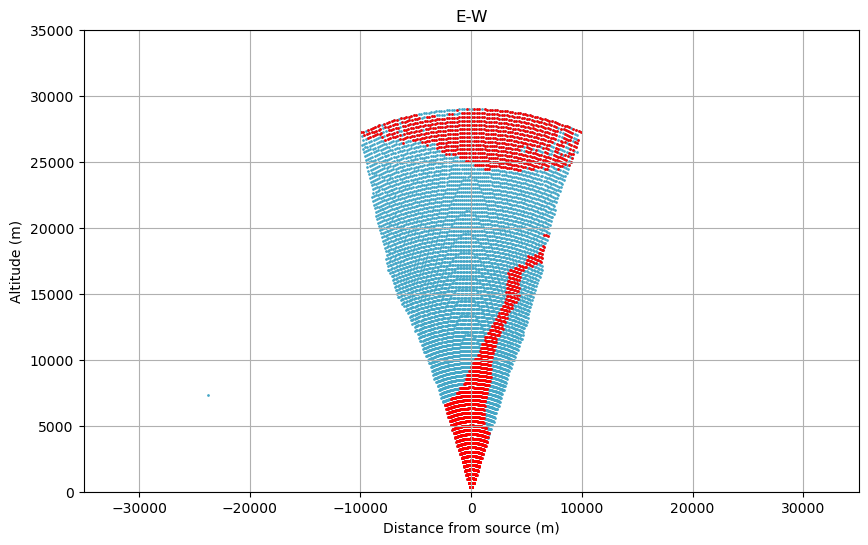

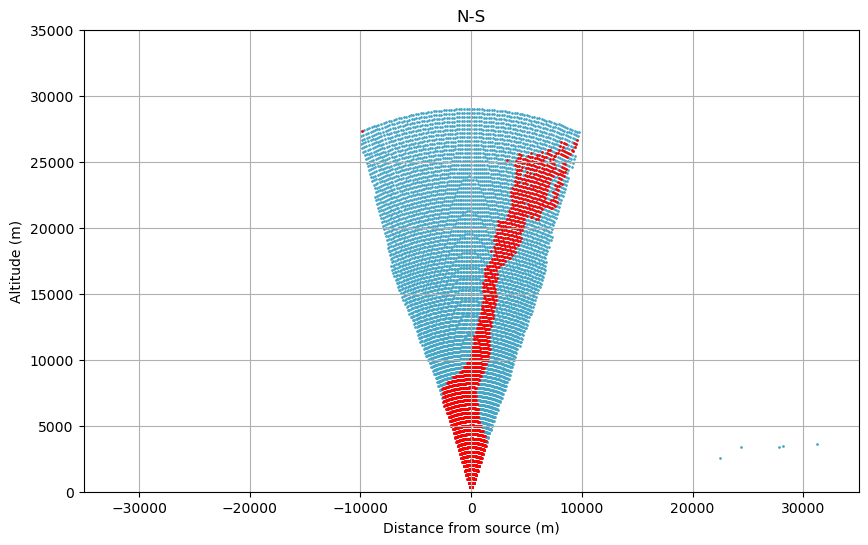

In [7]:
def process_and_plot(dfa, dist_axis, altitude_axis, title):
    group_t = dfa.groupby('time')

    for t in dfa['time'].unique():
        if t != 0:
            df_ = group_t.get_group(t).sort_values(dist_axis).drop_duplicates(subset=dist_axis).reset_index(drop=True)
            wave_eq = CubicSpline(df_[dist_axis], df_[altitude_axis])

            wi, land_wi = [], []

            for i in range(df_.shape[0]):
                x0 = df_.loc[i, dist_axis]
                dz_dx = wave_eq.derivative()(x0)
                if dz_dx != 0:
                    n_slope = np.rad2deg(np.arctan(-1 / dz_dx))

                    if np.abs(n_slope) >= 70:
                        land_x = x0 + wave_eq(x0) * dz_dx
                        wi.append(i)

                        if np.abs(land_x) <= 65:
                            land_wi.append(i)

            plt.scatter(df_.loc[wi, dist_axis], df_.loc[wi, altitude_axis], s=0.9, color='#43A6C6')
            plt.scatter(df_.loc[land_wi, dist_axis], df_.loc[land_wi, altitude_axis], s=0.9, color='red')

    dist = 1000 * 35

    plt.xlim((-dist, dist))
    plt.ylim((0, dist))
    plt.xlabel("Distance from source (m)")
    plt.ylabel("Altitude (m)")
    plt.title(title)
    # plt.legend()
    plt.grid()

dfa = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp_alglib_CS.csv')
plt.figure(figsize=(10, 6))

dfa_ew = dfa[(dfa['phi'] != 0) & (dfa['z'] >= 0) & (dfa['theta'] <= np.pi/2) & (dfa['theta'] >= -np.pi/2) & (dfa['phi'] >= 0)].reset_index(drop=True)
process_and_plot(dfa_ew, 'y', 'z','E-W')

plt.figure(figsize=(10, 6))
dfa_ns = dfa[(dfa['phi'] == 0) & (dfa['z'] >= 0) & (dfa['theta'] <= np.pi/2) & (dfa['theta'] >= -np.pi/2) & (dfa['phi'] >= 0)].reset_index(drop=True)
process_and_plot(dfa_ns, 'x', 'z', 'N-S')

plt.show()

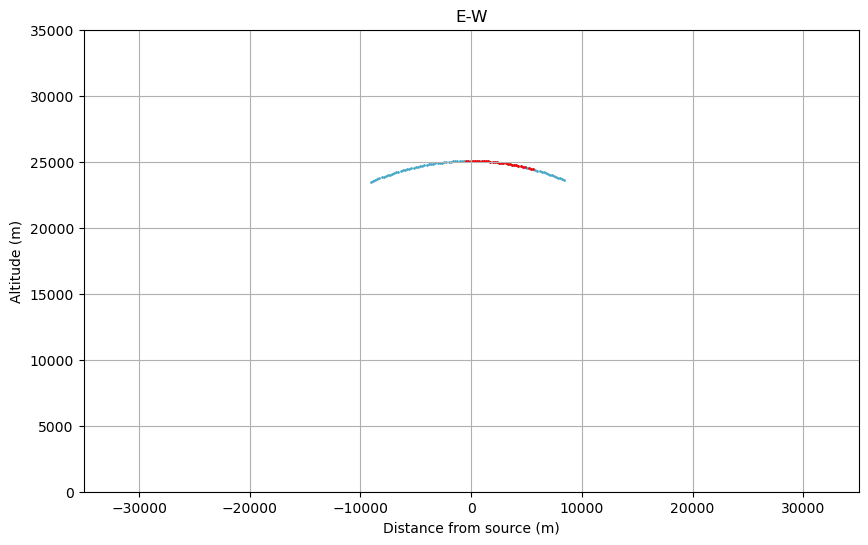

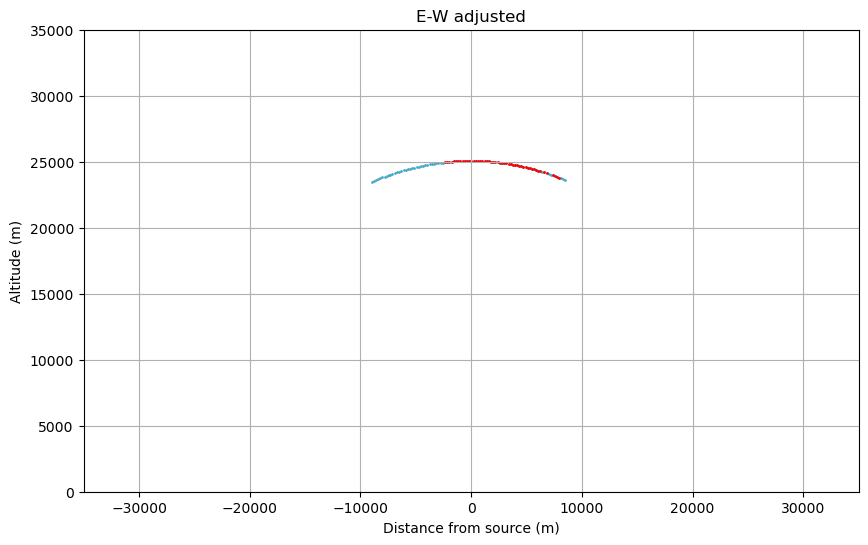

In [8]:
def count_points_in_window(start, end, sorted_array):
    return np.sum((sorted_array >= start) & (sorted_array <= end))

def window_points(xi, window_size, top_no_of_windows):
    top_windows, midpt_windows = [], []
    x_l_sorted = np.sort(xi)
    
    for i in range(len(x_l_sorted)):
        window_start = x_l_sorted[i]
        window_end = window_start + window_size
        
        count_points = count_points_in_window(window_start, window_end, x_l_sorted)
    
        if len(top_windows) < top_no_of_windows or count_points > top_windows[-1][2]:
            top_windows.append((window_start, window_end, count_points))
            midpt_windows.append((window_start+window_end)/2)

    top_windows, midpt_windows = zip(*sorted(zip(top_windows, midpt_windows), key=lambda x: x[0][2], reverse=True))
    top_windows = top_windows[:top_no_of_windows]
    midpt_windows = midpt_windows[:top_no_of_windows]

    return top_windows, midpt_windows
    
def process_and_plot(dfa, dist_axis, altitude_axis, title, time_slice):
    group_t = dfa.groupby('time')
    
    # Check if the requested time_slice exists in the data
    if time_slice not in group_t.groups:
        print(f"Time slice {time_slice} not found in the data.")
        return
    
    df_ = group_t.get_group(time_slice).sort_values(dist_axis).drop_duplicates(subset=dist_axis).reset_index(drop=True)
    wave_eq = CubicSpline(df_[dist_axis], df_[altitude_axis])

    wi, land_wi = [], []
    xi, land_xi = [], []

    for i in range(df_.shape[0]):
        x0 = df_.loc[i, dist_axis]
        dz_dx = wave_eq.derivative()(x0)
        if dz_dx != 0:
            n_slope = np.rad2deg(np.arctan(-1 / dz_dx))

            if np.abs(n_slope) >= 70:
                land_x = x0 + wave_eq(x0) * dz_dx
                wi.append(i)
                xi.append(land_x)
                
                if np.abs(land_x) <= 65:
                    land_wi.append(i)
                    land_xi.append(land_x)

    # plt.subplot(1, 2, subplot_position)
    plt.scatter(df_.loc[wi, dist_axis], df_.loc[wi, altitude_axis], s=0.9, color='#43A6C6')
    plt.scatter(df_.loc[land_wi, dist_axis], df_.loc[land_wi, altitude_axis], s=0.9, color='red')

    dist = 1000 * 35

    plt.xlim((-dist, dist))
    plt.ylim((0, dist))
    plt.xlabel("Distance from source (m)")
    plt.ylabel("Altitude (m)")
    plt.title(title)
    plt.grid()

    return xi, land_xi

dfa = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp_alglib_CS.csv')
dfa_ew = dfa[(dfa['phi'] != 0) & (dfa['z'] >= 0) & (dfa['theta'] <= np.pi/2) & (dfa['theta'] >= -np.pi/2)].reset_index(drop=True)

plt.figure(figsize=(10, 6))
time_slice = 83
dist_axis, altitude_axis = 'y', 'z'
window_size = 130
top_no_of_windows = 10

xi, land_xi = process_and_plot(dfa_ew, dist_axis, altitude_axis, 'E-W', time_slice)
top_windows, midpt_windows = window_points(xi,window_size,top_no_of_windows)

# for i, (start, end, count) in enumerate(top_windows):
#     print(f"Number of points in this window: {count} at centre: {(start + end)/2}:: midpoint{midpt_windows[i]}\n")

plt.figure(figsize=(10, 6))
dfa_ew[dist_axis] = dfa_ew[dist_axis] - midpt_windows[0]
process_and_plot(dfa_ew, dist_axis, altitude_axis, 'E-W adjusted', time_slice)
plt.show()

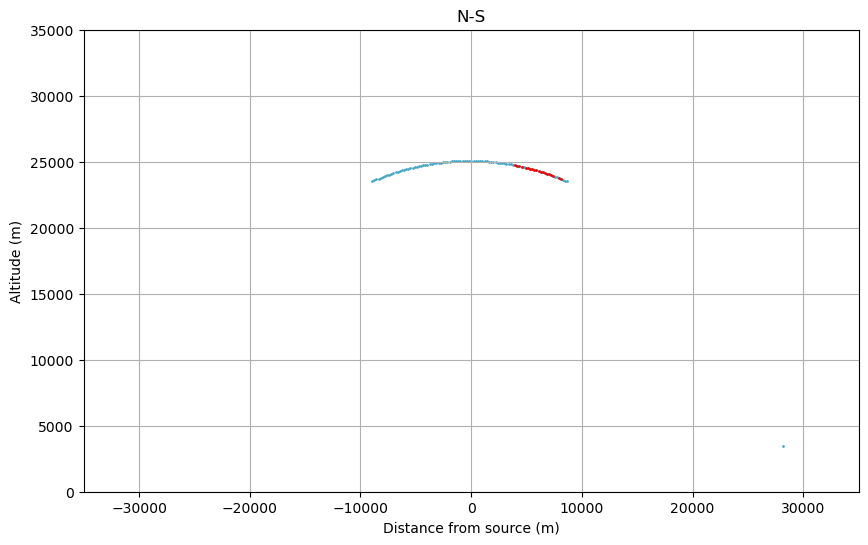

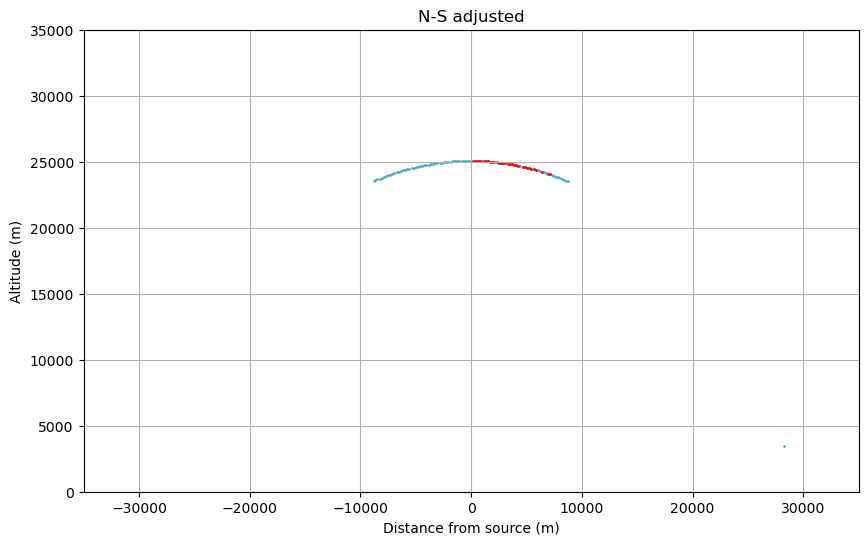

In [10]:
def count_points_in_window(start, end, sorted_array):
    return np.sum((sorted_array >= start) & (sorted_array <= end))

def window_points(xi, window_size, top_no_of_windows):
    top_windows, midpt_windows = [], []
    x_l_sorted = np.sort(xi)
    
    for i in range(len(x_l_sorted)):
        window_start = x_l_sorted[i]
        window_end = window_start + window_size
        
        count_points = count_points_in_window(window_start, window_end, x_l_sorted)
    
        if len(top_windows) < top_no_of_windows or count_points > top_windows[-1][2]:
            top_windows.append((window_start, window_end, count_points))
            midpt_windows.append((window_start+window_end)/2)

    top_windows, midpt_windows = zip(*sorted(zip(top_windows, midpt_windows), key=lambda x: x[0][2], reverse=True))
    top_windows = top_windows[:top_no_of_windows]
    midpt_windows = midpt_windows[:top_no_of_windows]

    return top_windows, midpt_windows
    
def process_and_plot(dfa, dist_axis, altitude_axis, title, time_slice):
    group_t = dfa.groupby('time')
    
    # Check if the requested time_slice exists in the data
    if time_slice not in group_t.groups:
        print(f"Time slice {time_slice} not found in the data.")
        return
    
    df_ = group_t.get_group(time_slice).sort_values(dist_axis).drop_duplicates(subset=dist_axis).reset_index(drop=True)
    wave_eq = CubicSpline(df_[dist_axis], df_[altitude_axis])

    wi, land_wi = [], []
    xi, land_xi = [], []

    for i in range(df_.shape[0]):
        x0 = df_.loc[i, dist_axis]
        dz_dx = wave_eq.derivative()(x0)
        if dz_dx != 0:
            n_slope = np.rad2deg(np.arctan(-1 / dz_dx))

            if np.abs(n_slope) >= 70:
                land_x = x0 + wave_eq(x0) * dz_dx
                wi.append(i)
                xi.append(land_x)
                
                if np.abs(land_x) <= 65:
                    land_wi.append(i)
                    land_xi.append(land_x)

    # plt.subplot(1, 2, subplot_position)
    plt.scatter(df_.loc[wi, dist_axis], df_.loc[wi, altitude_axis], s=0.9, color='#43A6C6')
    plt.scatter(df_.loc[land_wi, dist_axis], df_.loc[land_wi, altitude_axis], s=0.9, color='red')

    dist = 1000 * 35

    plt.xlim((-dist, dist))
    plt.ylim((0, dist))
    plt.xlabel("Distance from source (m)")
    plt.ylabel("Altitude (m)")
    plt.title(title)
    plt.grid()

    return xi, land_xi

dfa = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp_alglib_CS.csv')
dfa_ew = dfa[(dfa['phi'] == 0) & (dfa['z'] >= 0) & (dfa['theta'] <= np.pi/2) & (dfa['theta'] >= -np.pi/2)].reset_index(drop=True)

plt.figure(figsize=(10, 6))
time_slice = 83
dist_axis, altitude_axis = 'x', 'z'
window_size = 130
top_no_of_windows = 25

xi, land_xi = process_and_plot(dfa_ew, dist_axis, altitude_axis, 'N-S', time_slice)
top_windows, midpt_windows = window_points(xi,window_size,top_no_of_windows)

# for i, (start, end, count) in enumerate(top_windows):
#     print(f"Number of points in this window: {count} at centre: {(start + end)/2}:: midpoint{midpt_windows[i]}\n")

plt.figure(figsize=(10, 6))
dfa_ew[dist_axis] = dfa_ew[dist_axis] - midpt_windows[0]
process_and_plot(dfa_ew, dist_axis, altitude_axis, 'N-S adjusted', time_slice)
plt.show()

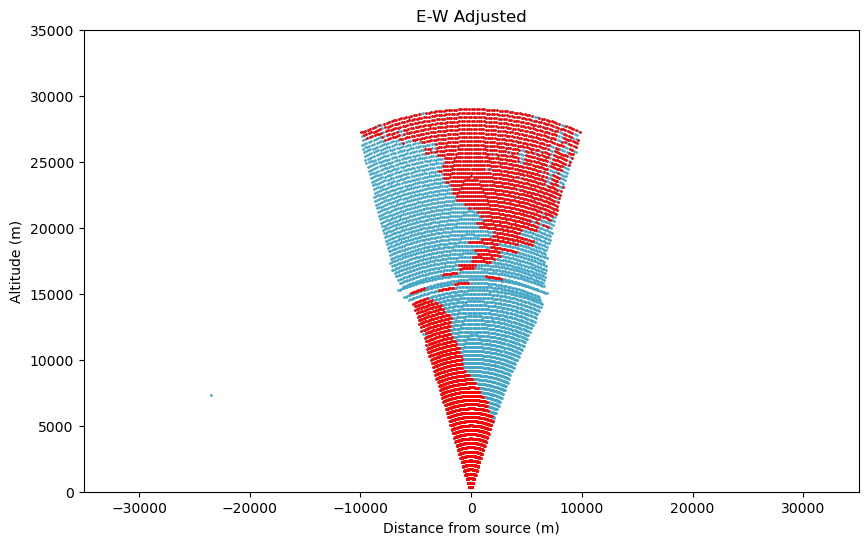

In [30]:
def count_points_in_window(start, end, sorted_array):
    return np.sum((sorted_array >= start) & (sorted_array <= end))

def window_points(xi, window_size, top_no_of_windows):
    top_windows, midpt_windows = [], []
    x_l_sorted = np.sort(xi)
    
    for i in range(len(x_l_sorted)):
        window_start = x_l_sorted[i]
        window_end = window_start + window_size
        
        count_points = count_points_in_window(window_start, window_end, x_l_sorted)
    
        if len(top_windows) < top_no_of_windows or count_points > top_windows[-1][2]:
            top_windows.append((window_start, window_end, count_points))
            midpt_windows.append((window_start + window_end) / 2)

    top_windows, midpt_windows = zip(*sorted(zip(top_windows, midpt_windows), key=lambda x: x[0][2], reverse=True))
    top_windows = top_windows[:top_no_of_windows]
    midpt_windows = midpt_windows[:top_no_of_windows]

    return top_windows, midpt_windows

def process_and_plot(dfa, dist_axis, altitude_axis, title, time_slice, Plt_flg):
    group_t = dfa.groupby('time')
    
    if time_slice not in group_t.groups:
        print(f"Time slice {time_slice} not found in the data.")
        return None, None
    
    df_ = group_t.get_group(time_slice).sort_values(dist_axis).drop_duplicates(subset=dist_axis).reset_index(drop=True)
    wave_eq = CubicSpline(df_[dist_axis], df_[altitude_axis])

    wi, land_wi = [], []
    xi, land_xi = [], []

    for i in range(df_.shape[0]):
        x0 = df_.loc[i, dist_axis]
        dz_dx = wave_eq.derivative()(x0)
        if dz_dx != 0:
            n_slope = np.rad2deg(np.arctan(-1 / dz_dx))

            if np.abs(n_slope) >= 70:
                land_x = x0 + wave_eq(x0) * dz_dx
                wi.append(i)
                xi.append(land_x)
                
                if np.abs(land_x) <= 65:
                    land_wi.append(i)
                    land_xi.append(land_x)
    if Plt_flg:
    # plt.subplot(1, 2, subplot_position)
        plt.scatter(df_.loc[wi, dist_axis], df_.loc[wi, altitude_axis], s=0.9, color='#43A6C6')
        plt.scatter(df_.loc[land_wi, dist_axis], df_.loc[land_wi, altitude_axis], s=0.9, color='red')
    
        dist = 1000 * 35
    
        plt.xlim((-dist, dist))
        plt.ylim((0, dist))
        plt.xlabel("Distance from source (m)")
        plt.ylabel("Altitude (m)")
        plt.title(title)
        plt.grid()

    return xi, land_xi

dfa = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp_alglib_CS.csv')
dfa_ew = dfa[(dfa['phi'] != 0) & (dfa['z'] >= 0) & (dfa['theta'] <= np.pi/2) & (dfa['theta'] >= -np.pi/2)].reset_index(drop=True)
dfa_ns = dfa[(dfa['phi'] == 0) & (dfa['z'] >= 0) & (dfa['theta'] <= np.pi/2) & (dfa['theta'] >= -np.pi/2)].reset_index(drop=True)

plt.figure(figsize=(10, 6))
dist_axis_x, dist_axis_y, altitude_axis = 'x','y', 'z'
window_size = 130
top_no_of_windows = 10

acoustic_source_loc = []

for time_slice in dfa_ew['time'].unique():
    if time_slice != 0:
        # xi, land_xi = process_and_plot(dfa_ew, dist_axis_y, altitude_axis, 1, 'E-W', time_slice)
        
        # if xi is not None:
        #     top_windows, midpt_windows = window_points(xi, window_size, top_no_of_windows)
            
        #     if top_windows:
        #         df_n = dfa_ew.copy()
        #         acoustic_source_loc.append(midpt_windows[0])
        #         df_n[dist_axis_y] = df_n[dist_axis_y] - midpt_windows[0]  
        #         process_and_plot(df_n, dist_axis_y, altitude_axis, 2, 'E-W Adjusted', time_slice)
                
        xi, land_xi = process_and_plot(dfa_ew, dist_axis_y, altitude_axis, 'E-W', time_slice, False)
        
        if xi is not None:
            top_windows, midpt_windows = window_points(xi, window_size, top_no_of_windows)
        
            if top_windows:
                df_n = dfa_ew.copy()
                acoustic_source_loc.append(midpt_windows[0])
                df_n[dist_axis_y] = df_n[dist_axis_y] - midpt_windows[0]
                process_and_plot(df_n, dist_axis_y, altitude_axis, 'E-W Adjusted', time_slice, True)
    
plt.show()

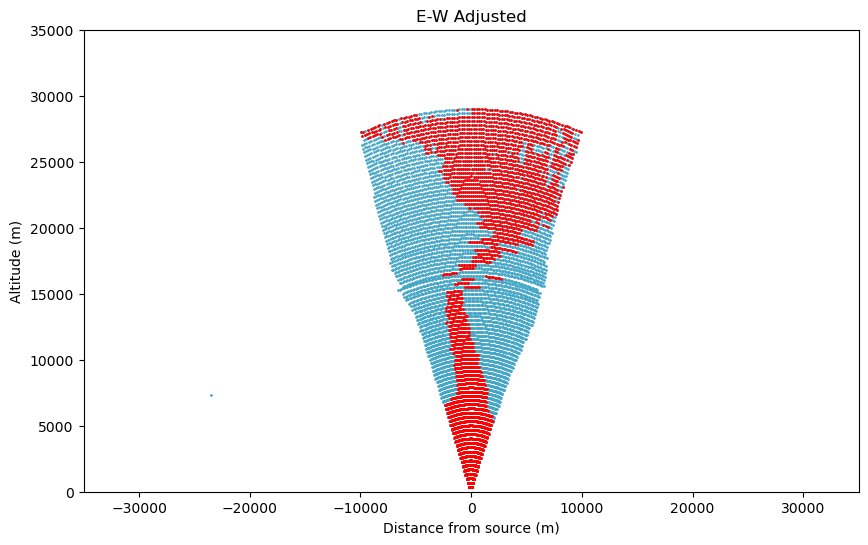

In [52]:
def count_points_in_window(start, end, sorted_array):
    return np.sum((sorted_array >= start) & (sorted_array <= end))

def window_points(xi, window_size, top_no_of_windows):
    top_windows, midpt_windows = [], []
    x_l_sorted = np.sort(xi)
    
    for i in range(len(x_l_sorted)):
        window_start = x_l_sorted[i]
        window_end = window_start + window_size
        
        count_points = count_points_in_window(window_start, window_end, x_l_sorted)
    
        if len(top_windows) < top_no_of_windows or count_points > top_windows[-1][2]:
            top_windows.append((window_start, window_end, count_points))
            midpt_windows.append((window_start + window_end) / 2)

    top_windows, midpt_windows = zip(*sorted(zip(top_windows, midpt_windows), key=lambda x: x[0][2], reverse=True))
    top_windows = top_windows[:top_no_of_windows]
    midpt_windows = midpt_windows[:top_no_of_windows]

    return top_windows, midpt_windows

def process_and_plot(dfa, dist_axis, altitude_axis, title, time_slice, plt_flg):
    group_t = dfa.groupby('time')
    
    if time_slice not in group_t.groups:
        print(f"Time slice {time_slice} not found in the data.")
        return None, None
    
    df_ = group_t.get_group(time_slice).sort_values(dist_axis).drop_duplicates(subset=dist_axis).reset_index(drop=True)
    wave_eq = CubicSpline(df_[dist_axis], df_[altitude_axis])

    wi, land_wi = [], []
    xi, land_xi = [], []

    for i in range(df_.shape[0]):
        x0 = df_.loc[i, dist_axis]
        dz_dx = wave_eq.derivative()(x0)
        if dz_dx != 0:
            n_slope = np.rad2deg(np.arctan(-1 / dz_dx))

            if np.abs(n_slope) >= 70:
                land_x = x0 + wave_eq(x0) * dz_dx
                wi.append(i)
                xi.append(land_x)
                
                if np.abs(land_x) <= 65:
                    land_wi.append(i)
                    land_xi.append(land_x)

    if plt_flg:
        plt.scatter(df_.loc[wi, dist_axis], df_.loc[wi, altitude_axis], s=0.9, color='#43A6C6')
        plt.scatter(df_.loc[land_wi, dist_axis], df_.loc[land_wi, altitude_axis], s=0.9, color='red')
    
        dist = 1000 * 35
    
        plt.xlim((-dist, dist))
        plt.ylim((0, dist))
        plt.xlabel("Distance from source (m)")
        plt.ylabel("Altitude (m)")
        plt.title(title)
        plt.grid()
        
    return xi, land_xi
    
def find_nearest_location(locations, current_loc):
    distances = np.abs(np.array(locations) - current_loc)
    nearest_index = np.argmin(distances)
    return locations[nearest_index]

dfa = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp_alglib_CS.csv')
dfa_ew = dfa[(dfa['phi'] != 0) & (dfa['z'] >= 0) & (dfa['theta'] <= np.pi/2) & (dfa['theta'] >= -np.pi/2)].reset_index(drop=True)

plt.figure(figsize=(10, 6))
dist_axis, altitude_axis = 'y', 'z'
window_size = 130
top_no_of_windows = 25

acoustic_source_loc = []
initial_loc = 0 

for time_slice in dfa_ew['time'].unique():
    if time_slice != 0:
        xi, land_xi = process_and_plot(dfa_ew, dist_axis, altitude_axis,  'E-W', time_slice, False)
        
        if xi is not None:
            top_windows, midpt_windows = window_points(xi, window_size, top_no_of_windows)
            
            if top_windows:
                nearest_loc = find_nearest_location(midpt_windows, initial_loc)
                acoustic_source_loc.append(nearest_loc)
                df_n = dfa_ew.copy()
                df_n[dist_axis] = df_n[dist_axis] - nearest_loc
                process_and_plot(df_n, dist_axis, altitude_axis,  'E-W Adjusted', time_slice, True)
                
plt.show()

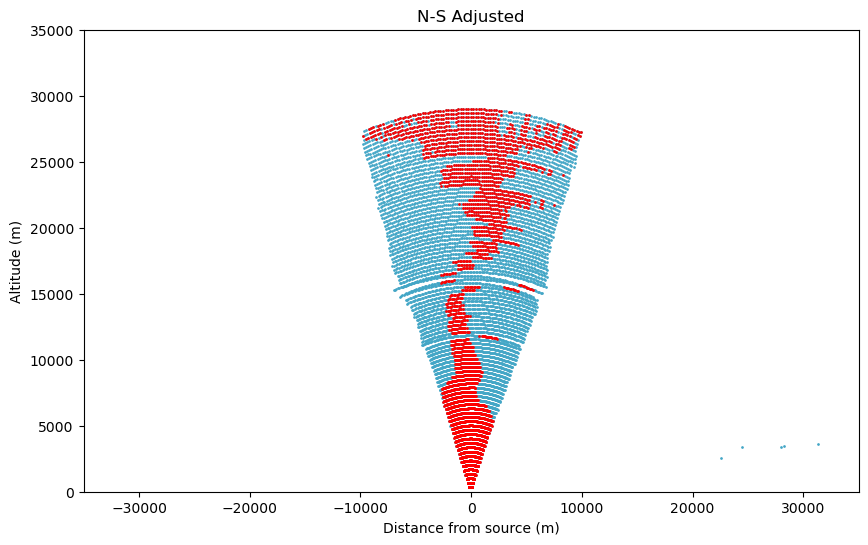

In [58]:
def count_points_in_window(start, end, sorted_array):
    return np.sum((sorted_array >= start) & (sorted_array <= end))

def window_points(xi, window_size, top_no_of_windows):
    top_windows, midpt_windows = [], []
    x_l_sorted = np.sort(xi)
    
    for i in range(len(x_l_sorted)):
        window_start = x_l_sorted[i]
        window_end = window_start + window_size
        
        count_points = count_points_in_window(window_start, window_end, x_l_sorted)
    
        if len(top_windows) < top_no_of_windows or count_points > top_windows[-1][2]:
            top_windows.append((window_start, window_end, count_points))
            midpt_windows.append((window_start + window_end) / 2)

    top_windows, midpt_windows = zip(*sorted(zip(top_windows, midpt_windows), key=lambda x: x[0][2], reverse=True))
    top_windows = top_windows[:top_no_of_windows]
    midpt_windows = midpt_windows[:top_no_of_windows]

    return top_windows, midpt_windows

def process_and_plot(dfa, dist_axis, altitude_axis, title, time_slice, plt_flg):
    group_t = dfa.groupby('time')
    
    if time_slice not in group_t.groups:
        print(f"Time slice {time_slice} not found in the data.")
        return None, None
    
    df_ = group_t.get_group(time_slice).sort_values(dist_axis).drop_duplicates(subset=dist_axis).reset_index(drop=True)
    wave_eq = CubicSpline(df_[dist_axis], df_[altitude_axis])

    wi, land_wi = [], []
    xi, land_xi = [], []

    for i in range(df_.shape[0]):
        x0 = df_.loc[i, dist_axis]
        dz_dx = wave_eq.derivative()(x0)
        if dz_dx != 0:
            n_slope = np.rad2deg(np.arctan(-1 / dz_dx))

            if np.abs(n_slope) >= 70:
                land_x = x0 + wave_eq(x0) * dz_dx
                wi.append(i)
                xi.append(land_x)
                
                if np.abs(land_x) <= 65:
                    land_wi.append(i)
                    land_xi.append(land_x)
    if plt_flg:
        plt.scatter(df_.loc[wi, dist_axis], df_.loc[wi, altitude_axis], s=0.9, color='#43A6C6')
        plt.scatter(df_.loc[land_wi, dist_axis], df_.loc[land_wi, altitude_axis], s=0.9, color='red')
    
        dist = 1000 * 35
    
        plt.xlim((-dist, dist))
        plt.ylim((0, dist))
        plt.xlabel("Distance from source (m)")
        plt.ylabel("Altitude (m)")
        plt.title(title)
        plt.grid()
        
    return xi, land_xi
    
def find_nearest_location(locations, current_loc):
    distances = np.abs(np.array(locations) - current_loc)
    nearest_index = np.argmin(distances)
    return locations[nearest_index]

dfa = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp_alglib_CS.csv')
dfa_ew = dfa[(dfa['phi'] == 0) & (dfa['z'] >= 0) & (dfa['theta'] <= np.pi/2) & (dfa['theta'] >= -np.pi/2)].reset_index(drop=True)

plt.figure(figsize=(10, 6))
dist_axis, altitude_axis = 'x', 'z'
window_size = 130
top_no_of_windows = 25

acoustic_source_loc = []
initial_loc = 0 

for time_slice in dfa_ew['time'].unique():
    if time_slice != 0:
        xi, land_xi = process_and_plot(dfa_ew, dist_axis, altitude_axis, 'E-W', time_slice, False)
        
        if xi is not None:
            top_windows, midpt_windows = window_points(xi, window_size, top_no_of_windows)
            
            if top_windows:
                nearest_loc = find_nearest_location(midpt_windows, initial_loc)
                acoustic_source_loc.append(nearest_loc)
                df_n = dfa_ew.copy()
                df_n[dist_axis] = df_n[dist_axis] - nearest_loc
                process_and_plot(df_n, dist_axis, altitude_axis, 'N-S Adjusted', time_slice, True)
                
plt.show()

96


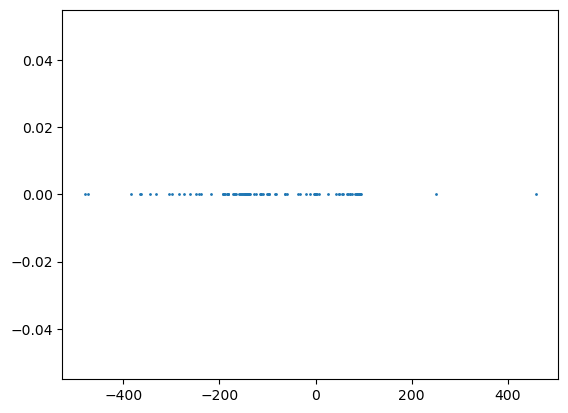

In [48]:
print(len(acoustic_source_loc))
plt.scatter(acoustic_source_loc,np.zeros(len(acoustic_source_loc)),s=1)
plt.show()

Cluster centers: [70.24880901745372, 89.0227398458039, 47.07454029388342, -0.5165054450894407, -98.58809763959857, -146.13246239275435, -168.74909374572456, -186.78784751832407, -113.04527723113802, -61.80980708188569] 



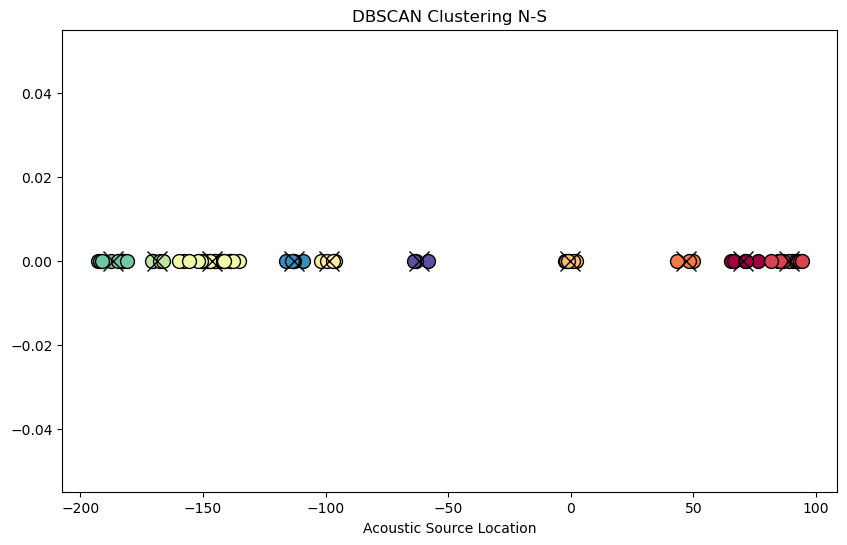

In [49]:
acoustic_source_loc = np.array(acoustic_source_loc).reshape(-1, 1)

eps = 5
min_samples = 3

db = DBSCAN(eps=eps,min_samples=min_samples).fit(acoustic_source_loc) 
labels = db.labels_

unique_labels = set(labels)
unique_labels.discard(-1)

cluster_centers = []

for k in unique_labels:
    class_member_mask = (labels == k)
    xy = acoustic_source_loc[class_member_mask]
    cluster_center = np.mean(xy)
    cluster_centers.append(cluster_center)

print(f'Cluster centers: {cluster_centers} \n')

plt.figure(figsize=(10, 6))
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = acoustic_source_loc[class_member_mask]
    plt.plot(xy, np.zeros_like(xy), 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=10)

for center in cluster_centers:
    plt.plot(center, 0, 'x', markerfacecolor='black', markeredgecolor='k', markersize=15)

plt.title('DBSCAN Clustering N-S')
plt.xlabel('Acoustic Source Location')
plt.show()

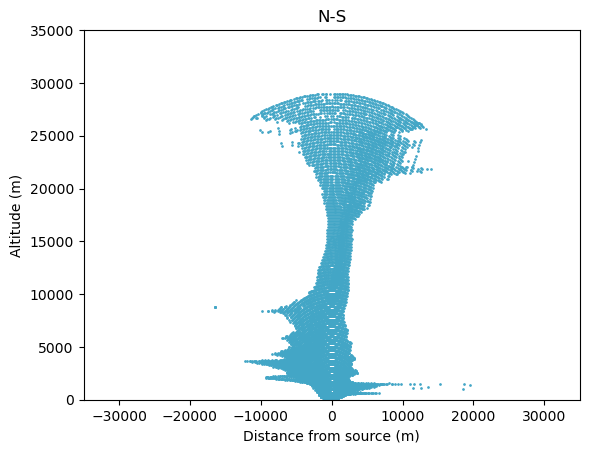

In [61]:
for center in cluster_centers:
    dfa_ew_n = dfa_ew.copy()
    dfa_ew_n['x'] = dfa_ew_n['x'] - center
    group_t = dfa_ew_n.groupby('time')
    
    for time_slice in dfa['time'].unique():
        if time_slice!=0:  
            df_ = group_t.get_group(time_slice).sort_values('x')
            df_ = df_.drop_duplicates(subset='x')
            wave_eq = CubicSpline(df_['x'],df_['z'])
            
            x_l = []
            y_l = []
            for x0 in df_['x'].to_numpy():
                dz_dx = wave_eq.derivative()(x0)
            
                land_x = x0 + wave_eq(x0) * dz_dx
                if np.abs(land_x) < 50:
                    x_l.append(x0)
                    y_l.append(wave_eq(x0))
            
            plt.scatter(x_l,y_l, s=0.9, color='#43A6C6')
    
    dist = 35 * 1000
    plt.xlim((-dist,dist))
    plt.ylim((0,dist))
    plt.xlabel("Distance from source (m)")
    plt.ylabel("Altitude (m)")
    plt.title('N-S')
    # plt.grid()

plt.show()

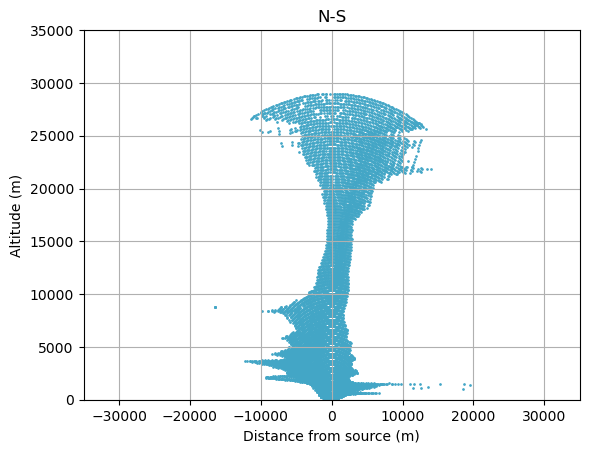

In [62]:
for center in cluster_centers:
    dfa_ew_n = dfa_ew.copy()
    dfa_ew_n['x'] = dfa_ew_n['x'] - center
    group_t = dfa_ew_n.groupby('time')
    
    for time_slice in dfa['time'].unique():
        if time_slice!=0:  
            df_ = group_t.get_group(time_slice).sort_values('x')
            df_ = df_.drop_duplicates(subset='x')
            wave_eq = CubicSpline(df_['x'],df_['z'])
            
            x_l = []
            y_l = []
            for x0 in df_['x'].to_numpy():
                dz_dx = wave_eq.derivative()(x0)
            
                land_x = x0 + wave_eq(x0) * dz_dx
                if np.abs(land_x) < 50:
                    x_l.append(x0)
                    y_l.append(wave_eq(x0))
            
            plt.scatter(x_l,y_l, s=0.9, color='#43A6C6')
    
    dist = 35 * 1000
    plt.xlim((-dist,dist))
    plt.ylim((0,dist))
    plt.xlabel("Distance from source (m)")
    plt.ylabel("Altitude (m)")
    plt.title('N-S')
    plt.grid()

plt.show()

96


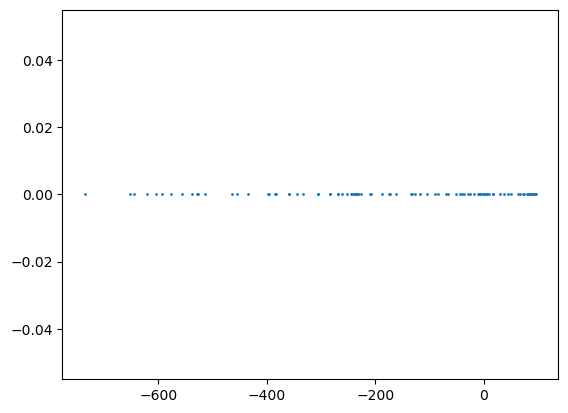

In [53]:
print(len(acoustic_source_loc))
plt.scatter(acoustic_source_loc,np.zeros(len(acoustic_source_loc)),s=1)
plt.show()

Cluster centers: [85.24453792155352, -1.3731725871423701, -131.60813413648506, -236.67566058151388, -40.58280508063732] 



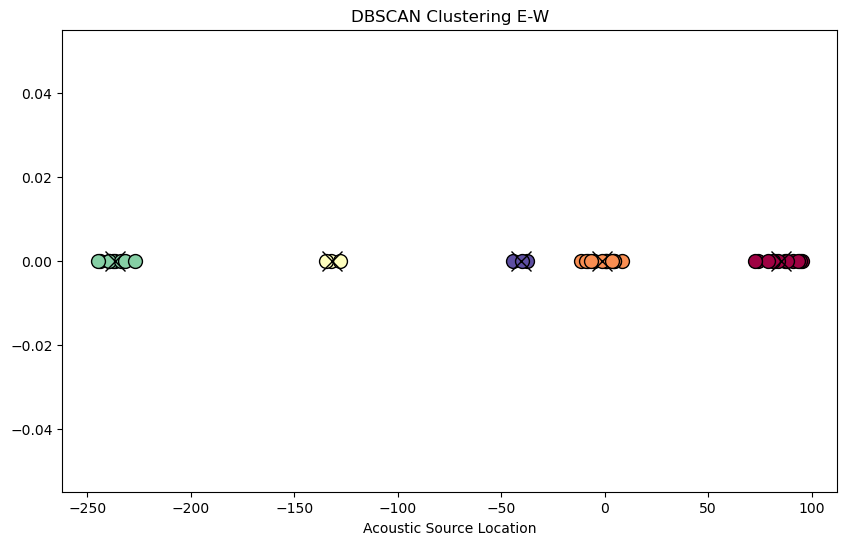

In [54]:
acoustic_source_loc = np.array(acoustic_source_loc).reshape(-1, 1)

eps = 5
min_samples = 3

db = DBSCAN(eps=eps,min_samples=min_samples).fit(acoustic_source_loc) 
labels = db.labels_

unique_labels = set(labels)
unique_labels.discard(-1)

cluster_centers = []

for k in unique_labels:
    class_member_mask = (labels == k)
    xy = acoustic_source_loc[class_member_mask]
    cluster_center = np.mean(xy)
    cluster_centers.append(cluster_center)

print(f'Cluster centers: {cluster_centers} \n')

plt.figure(figsize=(10, 6))
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = acoustic_source_loc[class_member_mask]
    plt.plot(xy, np.zeros_like(xy), 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=10)

for center in cluster_centers:
    plt.plot(center, 0, 'x', markerfacecolor='black', markeredgecolor='k', markersize=15)

plt.title('DBSCAN Clustering E-W')
plt.xlabel('Acoustic Source Location')
plt.show()

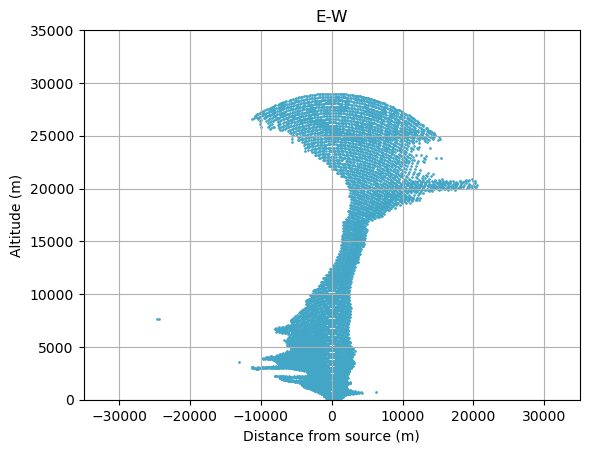

In [56]:
for center in cluster_centers:
    dfa_ew_n = dfa_ew.copy()
    dfa_ew_n['y'] = dfa_ew_n['y'] - center
    group_t = dfa_ew_n.groupby('time')
    
    for time_slice in dfa['time'].unique():
        if time_slice!=0:  
            df_ = group_t.get_group(time_slice).sort_values('y')
            df_ = df_.drop_duplicates(subset='y')
            wave_eq = CubicSpline(df_['y'],df_['z'])
            
            x_l = []
            y_l = []
            for x0 in df_['y'].to_numpy():
                dz_dx = wave_eq.derivative()(x0)
            
                land_x = x0 + wave_eq(x0) * dz_dx
                if np.abs(land_x) < 50:
                    x_l.append(x0)
                    y_l.append(wave_eq(x0))
            
            plt.scatter(x_l,y_l, s=0.9, color='#43A6C6')
    
    dist = 35 * 1000
    plt.xlim((-dist,dist))
    plt.ylim((0,dist))
    plt.xlabel("Distance from source (m)")
    plt.ylabel("Altitude (m)")
    plt.title('E-W')
    plt.grid()

plt.show()

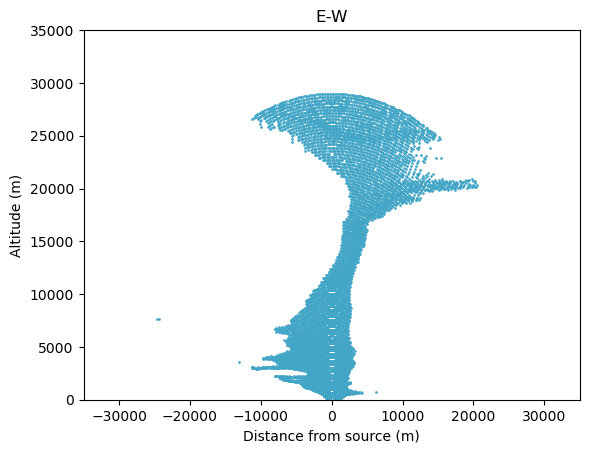

In [57]:
for center in cluster_centers:
    dfa_ew_n = dfa_ew.copy()
    dfa_ew_n['y'] = dfa_ew_n['y'] - center
    group_t = dfa_ew_n.groupby('time')
    
    for time_slice in dfa['time'].unique():
        if time_slice!=0:  
            df_ = group_t.get_group(time_slice).sort_values('y')
            df_ = df_.drop_duplicates(subset='y')
            wave_eq = CubicSpline(df_['y'],df_['z'])
            
            x_l = []
            y_l = []
            for x0 in df_['y'].to_numpy():
                dz_dx = wave_eq.derivative()(x0)
            
                land_x = x0 + wave_eq(x0) * dz_dx
                if np.abs(land_x) < 50:
                    x_l.append(x0)
                    y_l.append(wave_eq(x0))
            
            plt.scatter(x_l,y_l, s=0.9, color='#43A6C6')
    
    dist = 35 * 1000
    plt.xlim((-dist,dist))
    plt.ylim((0,dist))
    plt.xlabel("Distance from source (m)")
    plt.ylabel("Altitude (m)")
    plt.title('E-W')
    # plt.grid()

plt.show()

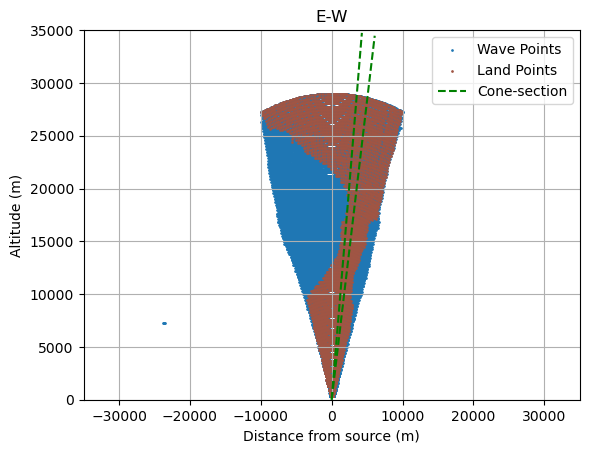

In [63]:
def angle_with_x_axis(x, y):
    return np.degrees(np.arctan2(y, x))

def points_in_cone(points, angle_start, angle_width):
    angle_end = angle_start + angle_width
    points_in_cone = []
    
    for point in points:
        x, y = point
        angle = angle_with_x_axis(x, y)
        
        if angle < 0:
            angle += 360
            
        if angle_start <= angle <= angle_end:
            points_in_cone.append(point)
    
    return points_in_cone

def drange(start, stop, step):
    while start < stop:
        yield start
        start += step

dfa = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp_alglib_CS.csv')

dfa_ew = dfa[(dfa['phi'] != 0) & (dfa['z'] >= 0) & (dfa['theta'] <= np.pi/2) & (dfa['theta'] >= -np.pi/2)].reset_index(drop=True)
cluster_centers = [85.24453792155352, -1.3731725871423701, -131.60813413648506, -236.67566058151388, -40.58280508063732]

points_l = [] 
points_w = []
for center in cluster_centers:
    dfa_ew_n = dfa_ew.copy()
    dfa_ew_n['y'] = dfa_ew_n['y'] - center
    group_t = dfa_ew_n.groupby('time')
    
    for time_slice in dfa['time'].unique():
        if time_slice != 0:  
            df_ = group_t.get_group(time_slice).sort_values('y')
            df_ = df_.drop_duplicates(subset='y').reset_index(drop=True)
            wave_eq = CubicSpline(df_['y'], df_['z'])
            
            for x0 in df_['y'].to_numpy():
                dz_dx = wave_eq.derivative()(x0)
                
                if dz_dx != 0:
                    n_slope = np.rad2deg(np.arctan(-1 / dz_dx))

                    if np.abs(n_slope) >= 70:
                        land_x = x0 + wave_eq(x0) * dz_dx
                        points_w.append((x0, df_.loc[df_['y'] == x0, 'z'].values[0]))
                        
                        if np.abs(land_x) < 65:
                            points_l.append((x0, df_.loc[df_['y'] == x0, 'z'].values[0]))

points_w = list(set(points_w))
points_l = list(set(points_l))

points_w = np.array(points_w)
points_l = np.array(points_l)

plt.scatter(points_w[:, 0], points_w[:, 1], s=0.9,label='Wave Points' )
plt.scatter(points_l[:, 0], points_l[:, 1], s=0.9, color='#A05544', label='Land Points')

dist = 35 * 1000
plt.xlim((-dist, dist))
plt.ylim((0, dist))
plt.xlabel("Distance from source (m)")
plt.ylabel("Altitude (m)")
plt.title('E-W')
plt.grid()

angle_width = 3

angle_start = 68
angle_end = 113 - angle_width
angle_step = 1

angle_f, percent_pts_f = 0, 0

for angle in drange(angle_start, angle_end, angle_step):
    points_within_cone_w = points_in_cone(points_w, angle, angle_width)
    points_within_cone_l = points_in_cone(points_l, angle, angle_width)
    percent_pts = (len(points_within_cone_l) / len(points_within_cone_w)) * 100 if len(points_within_cone_w) > 0 else 0
    if percent_pts_f <= percent_pts:
        angle_f = angle
        percent_pts_f = percent_pts

theta1 = np.radians(angle_f)
theta2 = np.radians(angle_f + angle_width)

plt.plot([0, np.cos(theta1) * dist], [0, np.sin(theta1) * dist], 'g--', label='Cone-section')
plt.plot([0, np.cos(theta2) * dist], [0, np.sin(theta2) * dist], 'g--')
# print(f"percentage inside the cone: {percent_pts_f}, angle betwween: {angle_f} - {angle_f + angle_width}")
plt.legend()
plt.show()

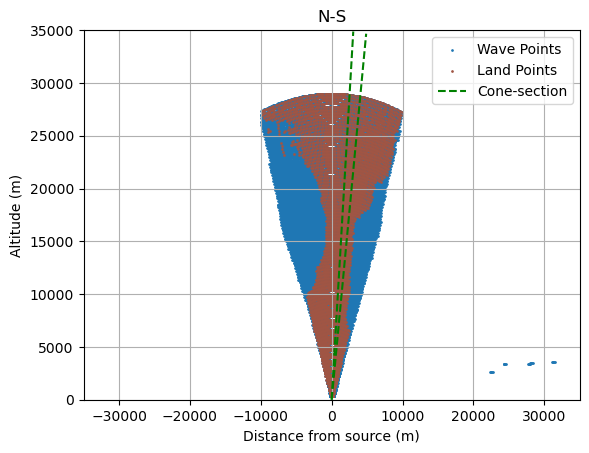

In [64]:
def angle_with_x_axis(x, y):
    return np.degrees(np.arctan2(y, x))

def points_in_cone(points, angle_start, angle_width):
    angle_end = angle_start + angle_width
    points_in_cone = []
    
    for point in points:
        x, y = point
        angle = angle_with_x_axis(x, y)
        
        if angle < 0:
            angle += 360
            
        if angle_start <= angle <= angle_end:
            points_in_cone.append(point)
    
    return points_in_cone

def drange(start, stop, step):
    while start < stop:
        yield start
        start += step

dfa = pd.read_csv('/home/murali/Documents/rass/simulation/in_py/reflected_waves/wTemp_wWind_cpp_alglib_CS.csv')
dist_axis, altitude_axis = 'x', 'z'

if dist_axis=='x':
    dfa_ew = dfa[(dfa['phi'] == 0) & (dfa[altitude_axis] >= 0) & (dfa['theta'] <= np.pi/2) & (dfa['theta'] >= -np.pi/2)].reset_index(drop=True)
    title = 'N-S'
else:
    dfa_ew = dfa[(dfa['phi'] != 0) & (dfa[altitude_axis] >= 0) & (dfa['theta'] <= np.pi/2) & (dfa['theta'] >= -np.pi/2)].reset_index(drop=True)
    title = 'E-W'
    
cluster_centers = [85.24453792155352, -1.3731725871423701, -131.60813413648506, -236.67566058151388, -40.58280508063732]

points_l = [] 
points_w = []
for center in cluster_centers:
    dfa_ew_n = dfa_ew.copy()
    dfa_ew_n[dist_axis] = dfa_ew_n[dist_axis] - center
    group_t = dfa_ew_n.groupby('time')
    
    for time_slice in dfa['time'].unique():
        if time_slice != 0:  
            df_ = group_t.get_group(time_slice).sort_values(dist_axis)
            df_ = df_.drop_duplicates(subset=dist_axis).reset_index(drop=True)
            wave_eq = CubicSpline(df_[dist_axis], df_[altitude_axis])
            
            for x0 in df_[dist_axis].to_numpy():
                dz_dx = wave_eq.derivative()(x0)
                
                if dz_dx != 0:
                    n_slope = np.rad2deg(np.arctan(-1 / dz_dx))

                    if np.abs(n_slope) >= 70:
                        land_x = x0 + wave_eq(x0) * dz_dx
                        points_w.append((x0, df_.loc[df_[dist_axis] == x0, altitude_axis].values[0]))
                        
                        if np.abs(land_x) < 65:
                            points_l.append((x0, df_.loc[df_[dist_axis] == x0, altitude_axis].values[0]))

points_w = list(set(points_w))
points_l = list(set(points_l))

points_w = np.array(points_w)
points_l = np.array(points_l)

plt.scatter(points_w[:, 0], points_w[:, 1], s=0.9,label='Wave Points' )
plt.scatter(points_l[:, 0], points_l[:, 1], s=0.9, color='#A05544', label='Land Points')

dist = 35 * 1000
plt.xlim((-dist, dist))
plt.ylim((0, dist))
plt.xlabel("Distance from source (m)")
plt.ylabel("Altitude (m)")
plt.title(title)
plt.grid()

angle_width = 3

angle_start = 68
angle_end = 113 - angle_width
angle_step = 1

angle_f, percent_pts_f = 0, 0

for angle in drange(angle_start, angle_end, angle_step):
    points_within_cone_w = points_in_cone(points_w, angle, angle_width)
    points_within_cone_l = points_in_cone(points_l, angle, angle_width)
    percent_pts = (len(points_within_cone_l) / len(points_within_cone_w)) * 100 if len(points_within_cone_w) > 0 else 0
    if percent_pts_f <= percent_pts:
        angle_f = angle
        percent_pts_f = percent_pts

theta1 = np.radians(angle_f)
theta2 = np.radians(angle_f + angle_width)

plt.plot([0, np.cos(theta1) * dist], [0, np.sin(theta1) * dist], 'g--', label='Cone-section')
plt.plot([0, np.cos(theta2) * dist], [0, np.sin(theta2) * dist], 'g--')
# print(f"percentage inside the cone: {percent_pts_f}, angle betwween: {angle_f} - {angle_f + angle_width}")
plt.legend()
plt.show()

In [66]:
df_soc = pd.read_csv('/home/murali/Documents/rass/automation/gen_data/acoustic_sources.csv')
df_soc

,cluster_Centers,axis,date,persent_pts,angle_start
0,58.796045,x,2021-04-01,39.675456,90
1,-2.758616,x,2021-04-01,39.675456,90
2,-60.277800,x,2021-04-01,39.675456,90
3,-141.484200,x,2021-04-01,39.675456,90
4,120.880130,x,2021-04-01,39.675456,90
...,...,...,...,...,...
3867,61.912043,y,2021-09-30 00:00:00,37.353171,101
3868,46.545744,y,2021-09-30 00:00:00,37.353171,101
3869,12.797158,y,2021-09-30 00:00:00,37.353171,101
3870,462.517313,y,2021-09-30 00:00:00,37.353171,101


In [ ]:
plt.scatter(df)